# Speed of Sound Prior Example

The main purpose of this code is to demonstrate how one can fix the prior-likelihood to a constant value and use multinest to sample the prior space log-uniformly. Within this script, one can use the ``PosteriorAnalysis.py``script to generate the prior axuiliary data and the prior 95% confidence intervals. 


The following block of code will properly import NEoST and its prerequisites, furthermore it also defines a name for the inference run, this name is what will be prefixed to all of NEoST's output files.

The machinary used within this script and the explanation of them is identical to those found in the Piecewise Polytropic, Speed of Sound, and Tabulated Examples.

In [1]:
import neost
from neost.eos import speedofsound
from neost.Prior import Prior
from neost.Star import Star
from neost.Likelihood import Likelihood
from neost import PosteriorAnalysis
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib
from matplotlib import pyplot
from pymultinest.solve import solve
import time
import os
#if not os.path.exists("chains"): 
#   os.mkdir("chains")

import neost.global_imports as global_imports

# Some physical constants
c = global_imports._c
G = global_imports._G
Msun = global_imports._M_s
pi = global_imports._pi
rho_ns = global_imports._rhons

# Define name for run
run_name = "prior-hebeler-cs-"

# We're exploring a speed of sound (CS) EoS parametrization with a chiral effective field theory (cEFT) parametrization based on Hebeler's work
# Transition between CS parametrisation and cEFT parametrization occurs at 1.1*saturation density
speedofsound_cs = speedofsound.SpeedofSoundEoS(crust = 'ceft-Hebeler', rho_t = 1.1*rho_ns)

using c code


Below, we define the speed of sound equation of state model, import the J0740 likelihood function, and define the number of stars.

In [2]:
# Create the likelihoods for the individual measurements
mass_radius_j0740 = np.load('../../examples/j0740.npy').T
J0740_LL = gaussian_kde(mass_radius_j0740)

# Pass the likelihoods to the solver
likelihood_functions = [J0740_LL.pdf]
likelihood_params = [['Mass', 'Radius']]

# Define whether event is GW or not and define number of stars/events
chirp_mass = [None]
number_stars = len(chirp_mass)

Similar to the posterior analysis tutorials, we define the static parameters (which there are none in this example), define and update the variable parameters for each source (one for this case), and define the prior object. Additionally, we define a ``loglike`` function, which defines a constant log-likelihood value for each sample drawn of each parameter (``pseudo_var``) This is defined in this way such that each sample has an equal likelihood of being drawn, thus we have a suffciently uniform and non-informative prior for each parameter in the equation of state.

In [3]:
# Define variable parameters, same prior as previous papers of Raaijmakers et al
variable_params={'ceft':[speedofsound_cs.min_norm, speedofsound_cs.max_norm],'a1':[0.1,1.5],'a2':[1.5,12.],'a3':[0.075,24.],'a4':[1.5,37.],'a5':[0.1,1.]}
for i in range(number_stars):
    variable_params.update({'rhoc_' + str(i+1):[14.6, 16]})

# Define static parameters, empty dict because all params are variable 
static_params={}

# Define prior
prior = Prior(speedofsound_cs, variable_params, static_params, chirp_mass)

print("Bounds of prior are")
print(variable_params)
print("number of parameters is %d" %len(variable_params))

# Define likelihood, pseudo_var is required as input because NEoST expects to be able to pass the parameter sample drawn from the prior to be passable to the likelihood
def loglike(pseudo_var):
    return 1.

Bounds of prior are
{'ceft': [1.676, 2.814], 'a1': [0.1, 1.5], 'a2': [1.5, 12.0], 'a3': [0.075, 24.0], 'a4': [1.5, 37.0], 'a5': [0.1, 1.0], 'rhoc_1': [14.6, 16]}
number of parameters is 7


In [4]:
# No prior & likelihood test, there is no likelihood after all
# print("Testing prior and likelihood")
# cube = np.random.rand(50, len(variable_params))
# for i in range(len(cube)):
#     par = prior.inverse_sample(cube[i])
#     print(likelihood.call(par))
# print("Testing done")

Here, we implement multinest to uniformly sample the prior space and for each sample from the prior that it draws it assigns a constant log-likelihood value of 1. Note, the greatly increased number of livepoints. This is required because each livepoint terminates after 1 iteration.

In [5]:
# Then we start the sampling, note the greatly increased number of livepoints, this is required because each livepoint terminates after 1 iteration
start = time.time()
result = solve(LogLikelihood=loglike, Prior=prior.inverse_sample, n_live_points=10000, evidence_tolerance=0.1,
               n_dims=len(variable_params), sampling_efficiency=0.8, outputfiles_basename='../../examples/chains/' + run_name, verbose=True)
end = time.time()
print(end - start)

  analysing data from ../../examples/chains/prior-hebeler-cs-.txt
818.3716564178467


Total number of samples is 10000
|████████████████████████████████████████| 10000/10000 [100%] in 28:13.4 (5.91/s) 
sample too small for 10000000000000000.00
sample too small for 2.35
sample too small for 2.40
sample too small for 2.46
sample too small for 2.51
sample too small for 2.57
sample too small for 2.62
sample too small for 2.68
sample too small for 2.73
sample too small for 2.79
sample too small for 2.84
sample too small for 2.90


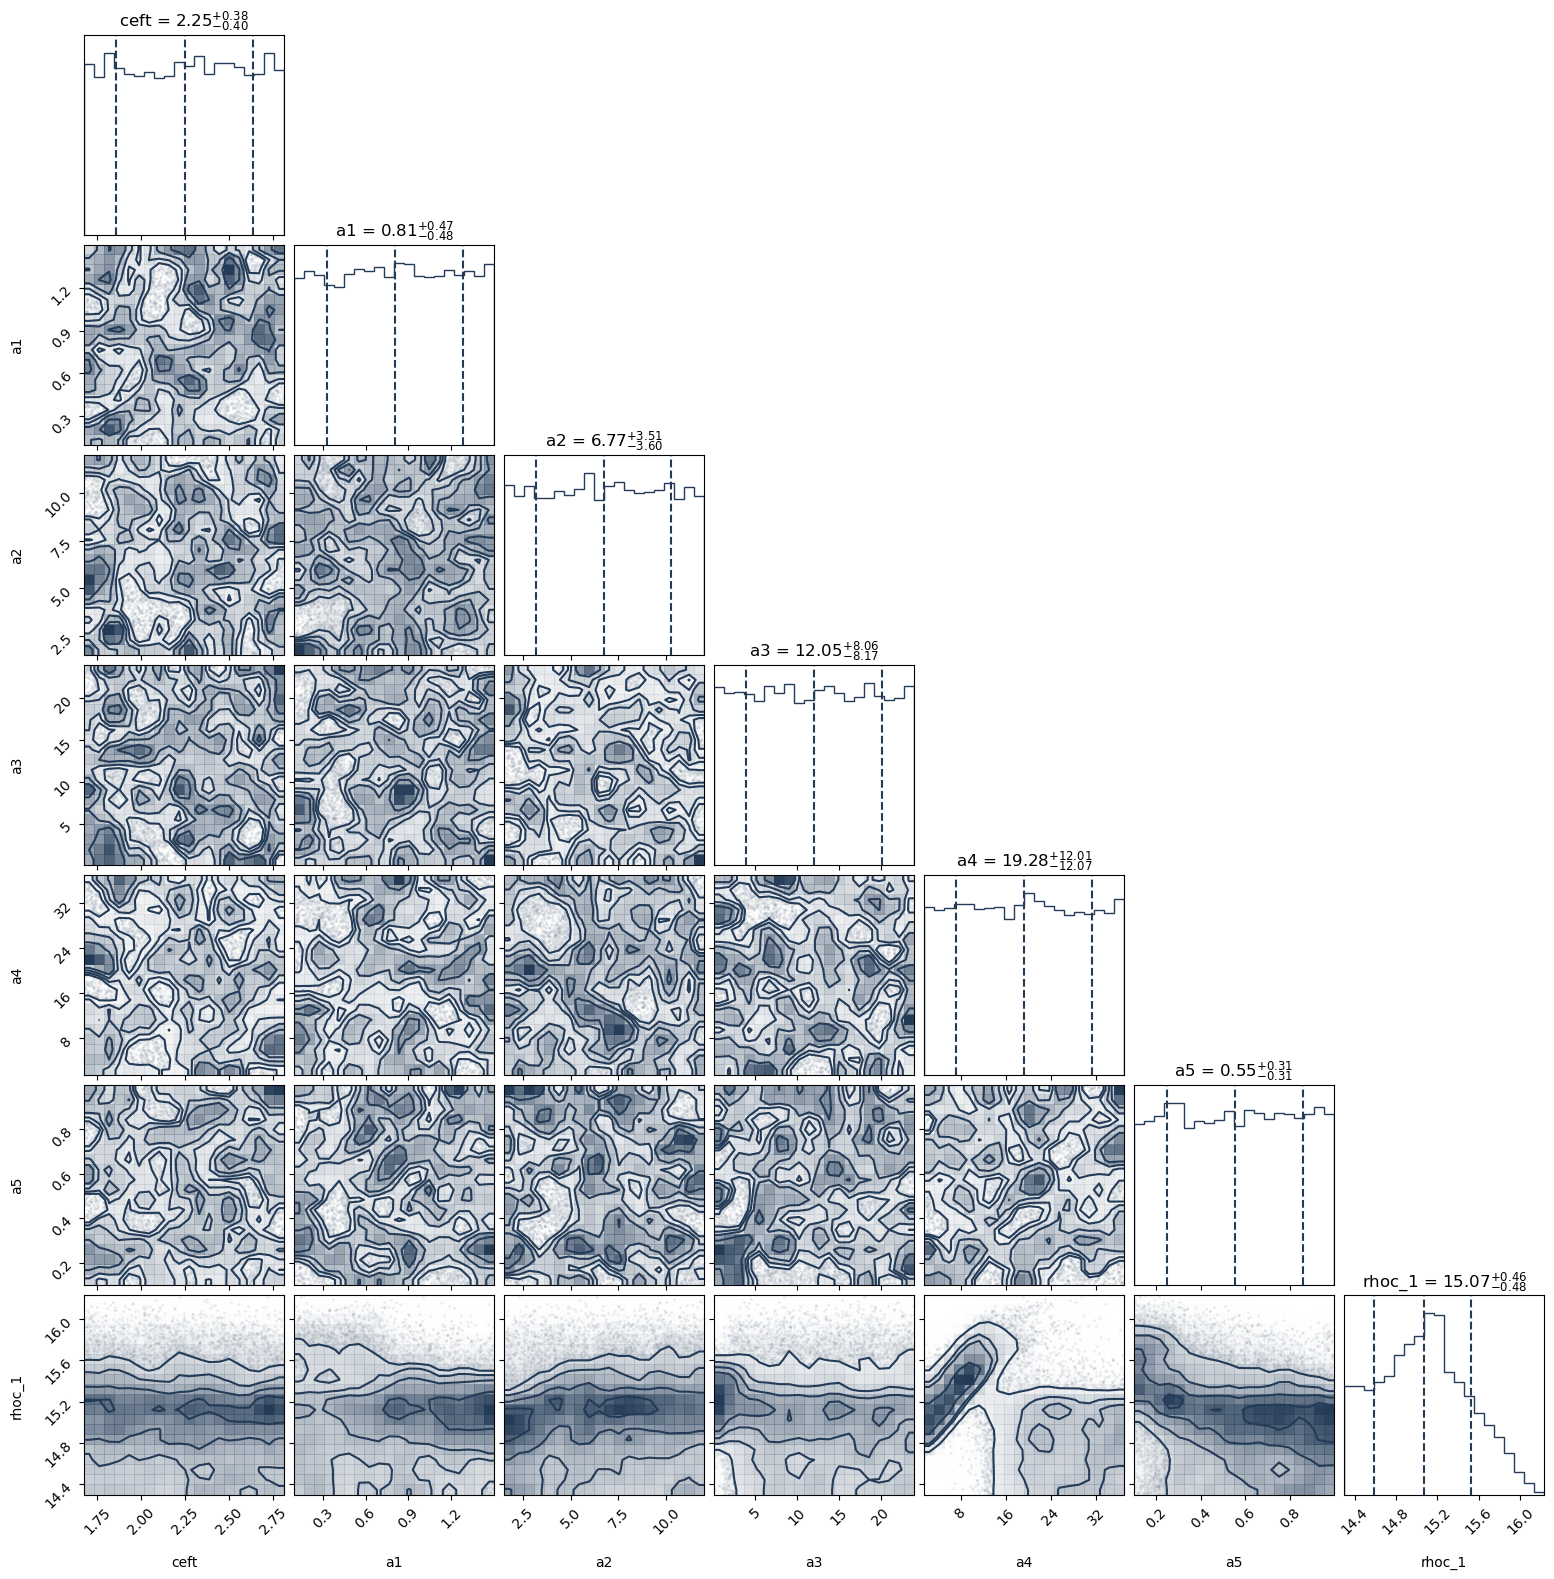

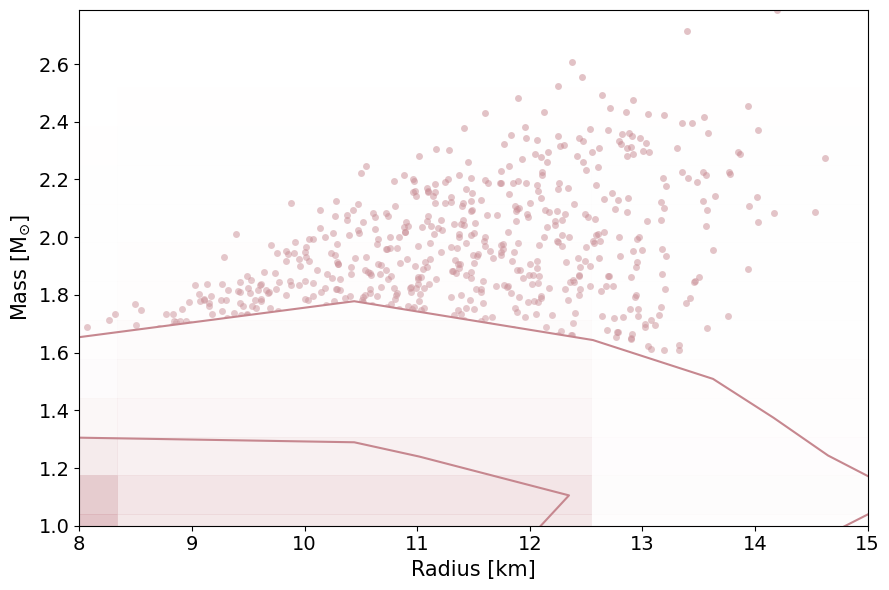

In [6]:
# Compute auxiliary data for posterior analysis
PosteriorAnalysis.compute_auxiliary_data('../../examples/chains/' + run_name, speedofsound_cs,
                                         variable_params, static_params, chirp_mass)


# Make some analysis plots
PosteriorAnalysis.cornerplot('../../examples/chains/' + run_name, variable_params)
PosteriorAnalysis.mass_radius_posterior_plot('../../examples/chains/' + run_name)
PosteriorAnalysis.mass_radius_prior_predictive_plot('../../examples/chains/' + run_name,variable_params, label_name='+ J0740 dataset')
PosteriorAnalysis.eos_posterior_plot('../../examples/chains/' + run_name,variable_params)